In [1]:
import numpy as np
import pandas as pd

import os.path as op
import numpy as np

from tqdm.contrib.itertools import product
import pingouin
from tms_risk.utils.data import get_subjects, get_all_behavior
import seaborn as sns

import matplotlib.pyplot as plt


stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

bids_folder = '/data/ds-tmsrisk/'

In [2]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    if n_voxels == 1:
        key = 'decoded_pdfs.volume.cv_voxel_selection'
    else:
        key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if natural_space:
        key += '.natural_space'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        if natural_space:
            pdf = pdf.loc[:, 5:112]
        else:
            pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, natural_space=natural_space)

    E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels,
                                'natural' if natural_space else 'log')],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'space']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E

In [3]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [1, 2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
# masks = ['NPCr1cm-surface', 'NPCr1cm-cluster', 'NPCr2cm-surface', 'NPCr2cm-cluster']
# n_voxels = [0, 1, 100]
masks = ['NPCr2cm-cluster']
n_voxels = [1]
natural_space = [True]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pdfs.append(get_pdf(sub, session, pcac, den, smooth, '/data/ds-tmsrisk/', mask, nv, ns))
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

  0%|          | 0/105 [00:00<?, ?it/s]

In [4]:
pred = pd.concat(pred)
pdf = pd.concat(pdfs)
df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:56: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_53977/884262180.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


In [9]:
r2.droplevel('stimulation_condition').unstack('session')['r'].corr()

session,1,2,3
session,,,
1,1.000000,0.115368,0.279087
2,0.115368,1.000000,0.359789
3,0.279087,0.359789,1.000000


In [6]:
pred['Stimulation condition'] = pred.index.get_level_values('stimulation_condition').map({'vertex': 'Vertex', 'ips': 'IPS', 'baseline':'Baseline'})
pred.set_index('Stimulation condition', append=True, inplace=True)

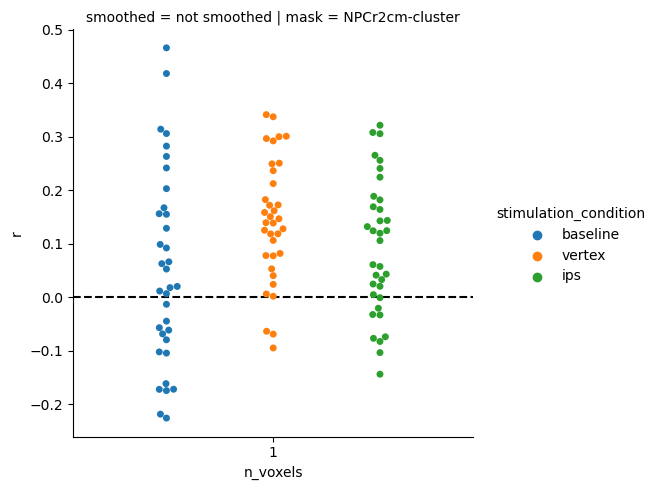

In [7]:
g = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='swarm', row='smoothed', dodge=True, ci=67)
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_56373/215189031.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 67)` for the same effect.

  g = sns.catplot(x='stimulation_condition', y='r', data=r2.drop('baseline', level='stimulation_condition').reset_index(), col='mask', kind='point', dodge=True, ci=67, palette=['k'])


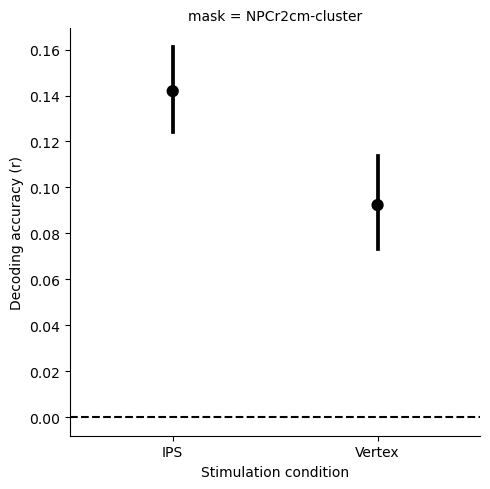

In [8]:
g = sns.catplot(x='stimulation_condition', y='r', data=r2.drop('baseline', level='stimulation_condition').reset_index(), col='mask', kind='point', dodge=True, ci=67, palette=['k'])
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))


g.set(ylabel='Decoding accuracy (r)', xlabel='Stimulation condition')
g.set_xticklabels(['IPS', 'Vertex'])




g.savefig(op.join(bids_folder, 'derivatives', 'figures', 'decoding.pdf'))

In [1]:
r

NameError: name 'r' is not defined

# Get the noise increase for each subject for flexible model

In [ ]:
from tms_risk.cogmodels.fit_model import build_model, get_data

In [66]:
tmp = r2.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').droplevel('session').unstack('stimulation_condition')['r']

pingouin.ttest(tmp['ips'], tmp['vertex'], True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.234307,34,two-sided,0.032145,"[-0.09, -0.0]",0.412123,1.611,0.658698


In [77]:
pred['n_bin'] = pd.cut(pred['n1'], np.arange(5, 100, 5), labels=np.arange(7.5, 97.5, 5))

In [78]:
pred['n_bin_q'] = pd.qcut(pred['n1'], 7)

pred['n_bin_q'] = pred['n_bin_q'].apply(lambda x: x.mid)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_94923/3079950012.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pred.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').groupby(['subject', 'stimulation_condition', 'n_bin']).mean().drop('baseline', level='stimulation_condition')


<Axes: xlabel='n_bin', ylabel='sd'>

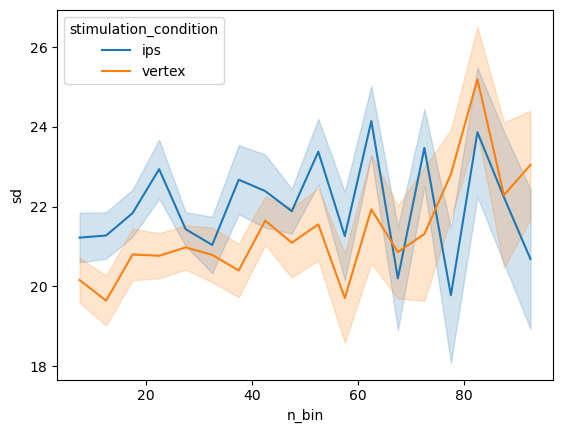

In [79]:
tmp = pred.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').groupby(['subject', 'stimulation_condition', 'n_bin']).mean().drop('baseline', level='stimulation_condition')

sns.lineplot(x='n_bin', y='sd', hue='stimulation_condition', data=tmp.reset_index(), errorbar='se')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_94923/888137233.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pred.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').groupby(['subject', 'Stimulation condition', 'n_bin_q']).mean().drop('Baseline', level='Stimulation condition')


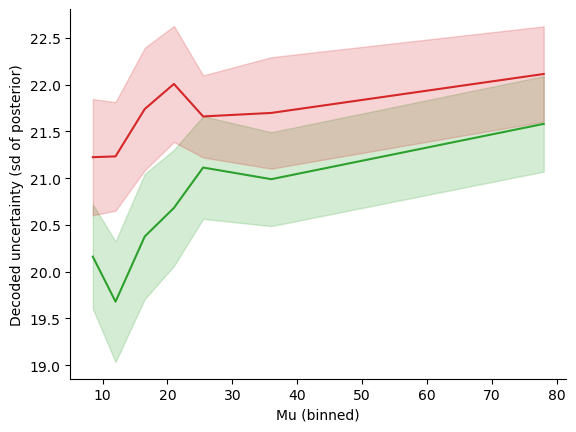

In [116]:
tmp = pred.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').groupby(['subject', 'Stimulation condition', 'n_bin_q']).mean().drop('Baseline', level='Stimulation condition')

g = sns.lineplot(x='n_bin_q', y='sd', hue='Stimulation condition', data=tmp.reset_index(), errorbar='se', palette=stimulation_palette, hue_order=stimulation_order, legend=False)

g.set(xlabel='Mu (binned)', ylabel='Decoded uncertainty (sd of posterior)')



# g.add_legend()
sns.despine()

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'decoding_sd.pdf'))
# g.savefig()

In [105]:
pred['error'] = pred['n1'] - pred['E']
pred['abs(error)'] = np.abs(pred['error'])

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_94923/962597191.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pred.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').groupby(['subject', 'Stimulation condition', 'n_bin_q']).mean().drop('Baseline', level='Stimulation condition')


(5.0, 40.0)

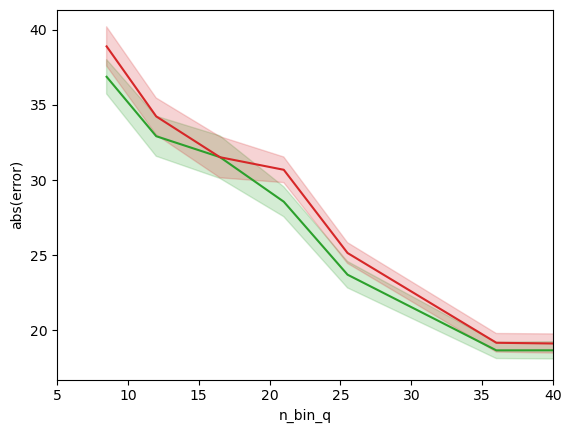

In [110]:
tmp = pred.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').groupby(['subject', 'Stimulation condition', 'n_bin_q']).mean().drop('Baseline', level='Stimulation condition')

sns.lineplot(x='n_bin_q', y='abs(error)', hue='Stimulation condition', data=tmp.reset_index(), errorbar='se', palette=stimulation_palette, hue_order=stimulation_order, legend=False)

plt.xlim(5, 40)